In [1]:
import pandas as pd
wine_df = pd.read_csv('../newdataset/new_winequality.csv')
diabetes_df = pd.read_csv('../newdataset/new_diabetes.csv')

In [2]:
from sklearn.model_selection import train_test_split

# 資料分割 def
def split_data(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets.
    
    Parameters:
        df (pandas.DataFrame): The input data frame.
        target_column (str): The name of the column to use as the target variable.
        test_size (float, optional): The proportion of the dataset to include in the test split.
        random_state (int, optional): Controls the shuffling applied to the data before applying the split.
        
    Returns:
        X_train (pandas.DataFrame): Training feature dataset.
        X_test (pandas.DataFrame): Testing feature dataset.
        y_train (pandas.Series): Training target dataset.
        y_test (pandas.Series): Testing target dataset.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Usage example:
# Assuming 'origin_train_df' is your DataFrame and 'quality' is the target column
# X_train, X_test, y_train, y_test = split_data(origin_train_df, 'quality')
# print(X_train, y_train)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = split_data(wine_df, 'quality')
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_data(diabetes_df, 'diabetes')

In [3]:
from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaler(X_train, X_test):
    """
    Applies MinMax scaling to the training and testing datasets.
    
    Parameters:
        X_train (pandas.DataFrame): The training feature dataset.
        X_test (pandas.DataFrame): The testing feature dataset.
    z
    Returns:
        X_train_scaled (pandas.DataFrame): Scaled training feature dataset.
        X_test_scaled (pandas.DataFrame): Scaled testing feature dataset.
    """
    scaler = MinMaxScaler()
    scaler.fit(X_train)  # Fit the scaler to the training data only
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert the scaled arrays back to DataFrame for better handling in pandas
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    return X_train_scaled, X_test_scaled

# 使用範例:
# X_train_scaled, X_test_scaled = apply_minmax_scaler(X_train, X_test)
X_train_scaled_wine, X_test_scaled_wine = apply_minmax_scaler(X_train_wine, X_test_wine)
X_train_scaled_diabetes, X_test_scaled_diabetes = apply_minmax_scaler(X_train_diabetes, X_test_diabetes)

In [4]:
from imblearn.under_sampling import RandomUnderSampler
def random_undersampling(X_train, y_train):
    """
    Applies random oversampling to balance the class distribution in the training dataset.

    Parameters:
        X_train (pandas.DataFrame): The training feature dataset.
        y_train (pandas.Series): The training target dataset.

    Returns:
        X_train_ros (pandas.DataFrame): Oversampled training feature dataset.
        y_train_ros (pandas.Series): Oversampled training target dataset.
    """
    ros = RandomUnderSampler(random_state=42)
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
    
    return X_train_ros, y_train_ros

# 使用範例:
X_train_rus_wine, y_train_rus_wine = random_undersampling(X_train_scaled_wine, y_train_wine)
X_train_rus_dia, y_train_rus_dia = random_undersampling(X_train_scaled_diabetes, y_train_diabetes)

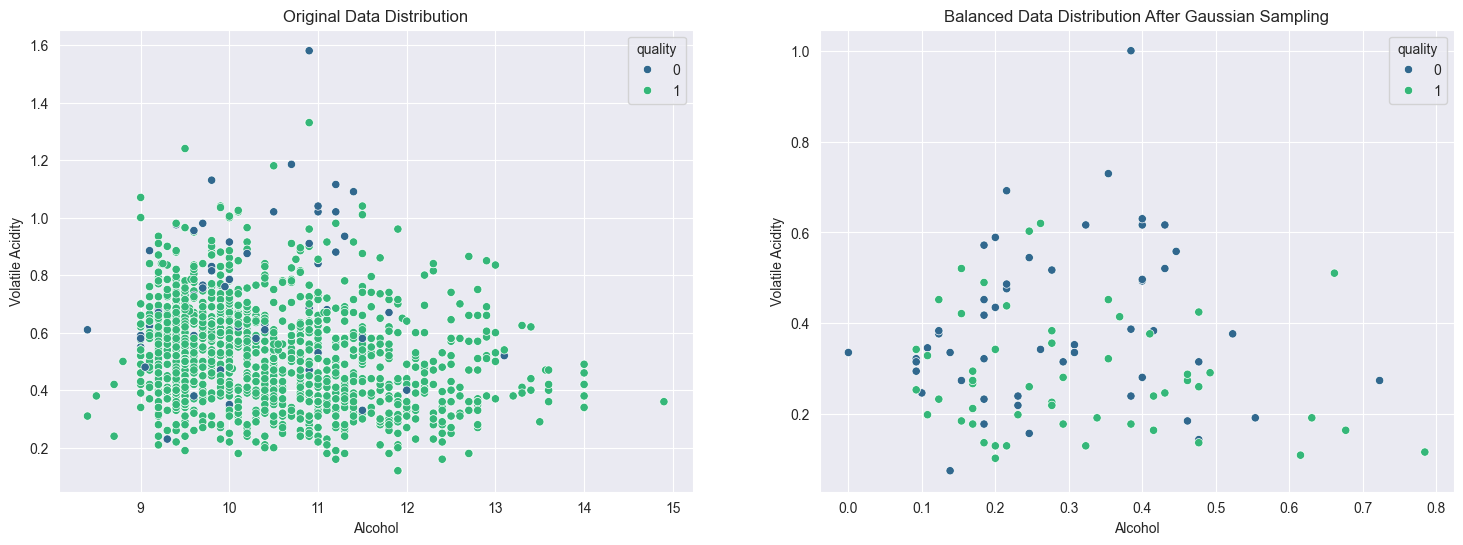

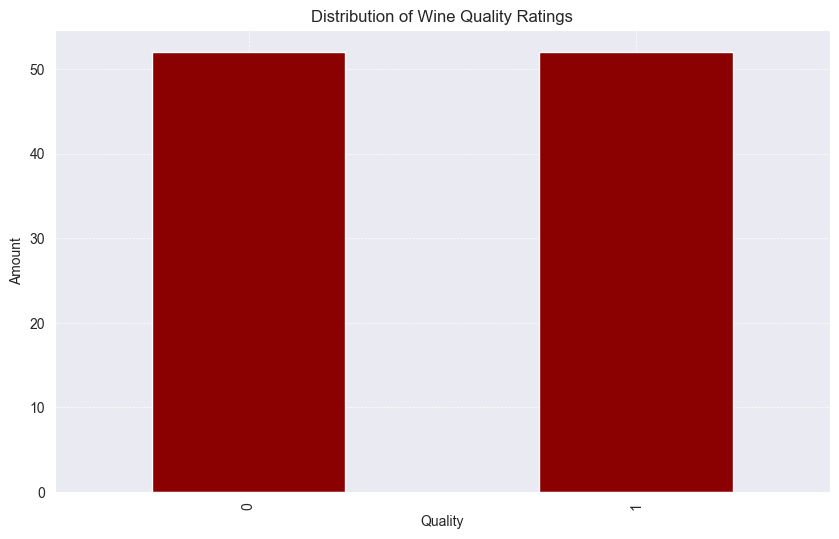

In [5]:
# 将过采样的特征和目标组合成一个DataFrame
rus_train_df = pd.DataFrame(X_train_rus_wine, columns=wine_df.columns[:-1])
rus_train_df['quality'] = y_train_rus_wine

import seaborn as sns
import matplotlib.pyplot as plt
# Setting up the subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Original data plot
sns.scatterplot(ax=ax[0], data=wine_df, x='alcohol', y='volatile acidity', hue='quality', palette='viridis')
ax[0].set_title('Original Data Distribution')
ax[0].set_xlabel('Alcohol')
ax[0].set_ylabel('Volatile Acidity')

# Balanced data plot
sns.scatterplot(ax=ax[1], data=rus_train_df, x='alcohol', y='volatile acidity', hue='quality', palette='viridis')
ax[1].set_title('Balanced Data Distribution After Gaussian Sampling')
ax[1].set_xlabel('Alcohol')
ax[1].set_ylabel('Volatile Acidity')
plt.show()

plt.figure(figsize=(10, 6))
rus_train_df['quality'].value_counts().sort_index().plot(kind='bar', color='darkred')
plt.title('Distribution of Wine Quality Ratings')
plt.xlabel('Quality')
plt.ylabel('Amount')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
import numpy as np

In [7]:
def display_confusion_matrix(y_true, y_pred):
    """
    Displays confusion matrix with labels for better readability.

    Parameters:
        y_true (array-like): True labels of the data.
        y_pred (array-like): Predicted labels by the model.

    Returns:
        A formatted confusion matrix as a Pandas DataFrame.
    """
    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Assuming binary classification for simplicity; adjust if needed for multi-class
    cm_df = pd.DataFrame(cm, 
                         index=['Actual Negative:0', 'Actual Positive:1'], 
                         columns=['Predicted Negative:0', 'Predicted Positive:1'])

    # Extracting TN, FP, FN, TP
    # TN, FP, FN, TP = cm.ravel()
    # print(f"True Negatives (TN): {TN}")
    # print(f"False Positives (FP): {FP}")
    # print(f"False Negatives (FN): {FN}")
    # print(f"True Positives (TP): {TP}")

    return cm_df

In [8]:
def train_evaluate_lr(X_train, X_test, y_train, y_test, model_name='Logistic Regression'):
    lr_model = LogisticRegression(random_state=42)
    lr_model.fit(X_train, y_train)
    predictions = lr_model.predict(X_test)

    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, predictions, zero_division=1))
    print("Confusion Matrix:\n", display_confusion_matrix(y_test, predictions))

    # ROC Curve
    probs = lr_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# lr_wine_result = train_evaluate_lr(X_train_scaled_wine, X_test_scaled_wine, y_train_wine, y_test_wine)
# lr_diabetes_result = train_evaluate_lr(X_train_scaled_diabetes, X_test_scaled_diabetes, y_train_diabetes, y_test_diabetes)

In [9]:
def train_evaluate_rf(X_train, X_test, y_train, y_test, model_name='Random Forest'):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)

    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", display_confusion_matrix(y_test, predictions))

    # ROC Curve
    probs = rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# rf_wine_result = train_evaluate_rf(X_train_scaled_wine, X_test_scaled_wine, y_train_wine, y_test_wine)
# rf_diabetes_result = train_evaluate_rf(X_train_scaled_diabetes, X_test_scaled_diabetes, y_train_diabetes, y_test_diabetes)

In [10]:
def train_evaluate_svm(X_train, X_test, y_train, y_test, model_name='SVM'):
    # 初始化SVM模型
    svm_model = SVC(kernel='linear', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)  # 训练模型
    predictions = svm_model.predict(X_test)  # 进行预测

    # 打印性能指标
    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, predictions, zero_division=1))
    print("Confusion Matrix:\n", display_confusion_matrix(y_test, predictions))

    # ROC 曲線
    probs = svm_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# 使用例子
# 假设X_train, X_test, y_train, y_test已经被定义和准备好了
# train_evaluate_svm(X_train, X_test, y_train, y_test)

Wine Dataset Logistic Regression:
Accuracy: 0.678125
F1 Score: 0.7788365295403438
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.91      0.16        11
           1       1.00      0.67      0.80       309

    accuracy                           0.68       320
   macro avg       0.54      0.79      0.48       320
weighted avg       0.96      0.68      0.78       320

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                    10                     1
Actual Positive:1                   102                   207


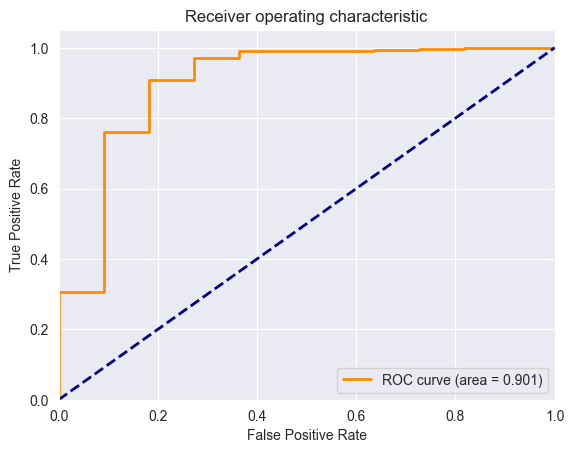

Wine Dataset Random Forest:
Accuracy: 0.709375
F1 Score: 0.8014391636437951
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.82      0.16        11
           1       0.99      0.71      0.82       309

    accuracy                           0.71       320
   macro avg       0.54      0.76      0.49       320
weighted avg       0.96      0.71      0.80       320

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                     9                     2
Actual Positive:1                    91                   218


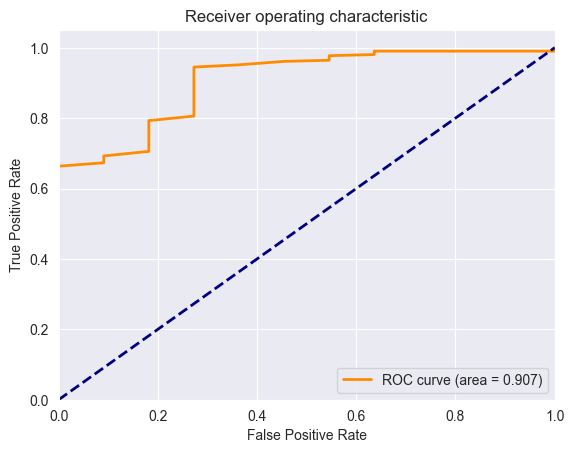

Wine Dataset SVM:
Accuracy: 0.671875
F1 Score: 0.77425
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.91      0.16        11
           1       1.00      0.66      0.80       309

    accuracy                           0.67       320
   macro avg       0.54      0.79      0.48       320
weighted avg       0.96      0.67      0.77       320

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                    10                     1
Actual Positive:1                   104                   205


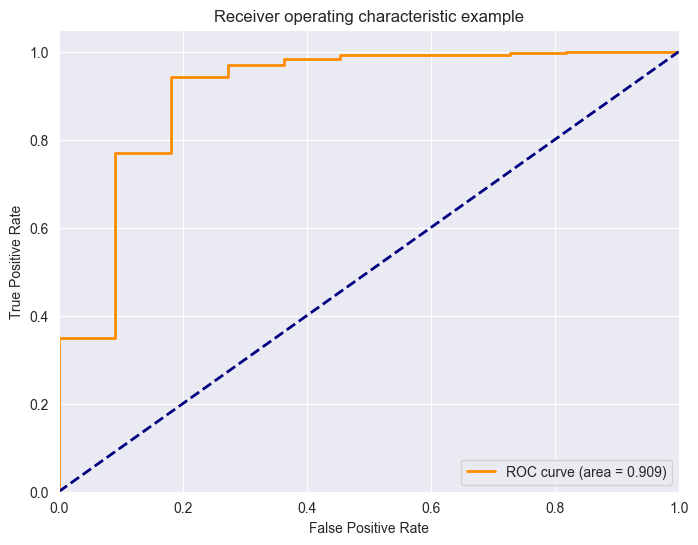

In [11]:
lr_wine_result = train_evaluate_lr(X_train_rus_wine, X_test_scaled_wine, y_train_rus_wine, y_test_wine, model_name='Wine Dataset Logistic Regression')
rf_wine_result = train_evaluate_rf(X_train_rus_wine, X_test_scaled_wine, y_train_rus_wine, y_test_wine, model_name='Wine Dataset Random Forest')
svm_wine_result = train_evaluate_svm(X_train_rus_wine, X_test_scaled_wine, y_train_rus_wine, y_test_wine, model_name='Wine Dataset SVM')

Diabetes Dataset Logistic Regression:
Accuracy: 0.88805
F1 Score: 0.9045602385317306
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     18292
           1       0.42      0.88      0.57      1708

    accuracy                           0.89     20000
   macro avg       0.71      0.88      0.75     20000
weighted avg       0.94      0.89      0.90     20000

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                 16264                  2028
Actual Positive:1                   211                  1497


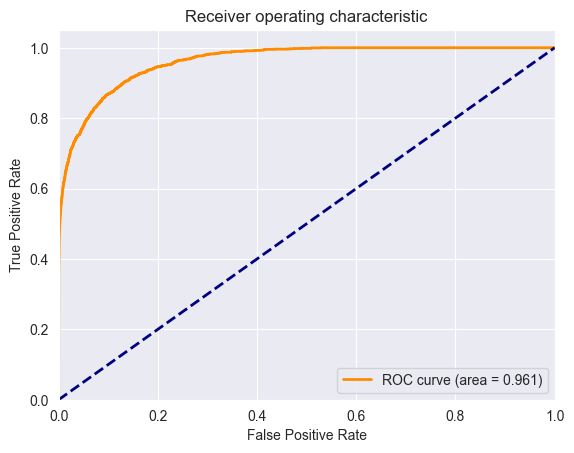

Diabetes Dataset Random Forest:
Accuracy: 0.90255
F1 Score: 0.9160021210705194
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     18292
           1       0.46      0.91      0.61      1708

    accuracy                           0.90     20000
   macro avg       0.73      0.90      0.78     20000
weighted avg       0.95      0.90      0.92     20000

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                 16504                  1788
Actual Positive:1                   161                  1547


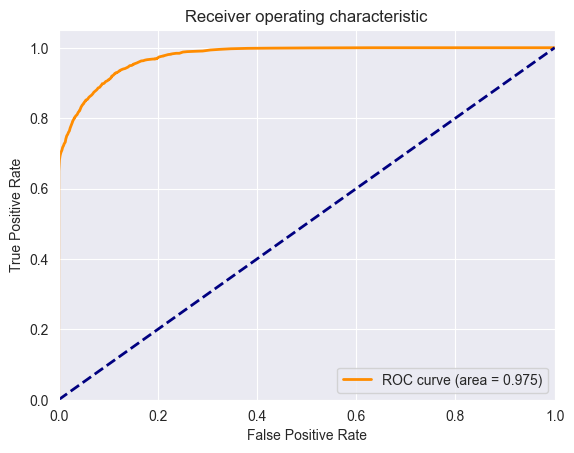

Diabetes Dataset SVM:
Accuracy: 0.8872
F1 Score: 0.90403085497175
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     18292
           1       0.42      0.88      0.57      1708

    accuracy                           0.89     20000
   macro avg       0.71      0.88      0.75     20000
weighted avg       0.94      0.89      0.90     20000

Confusion Matrix:
                    Predicted Negative:0  Predicted Positive:1
Actual Negative:0                 16237                  2055
Actual Positive:1                   201                  1507


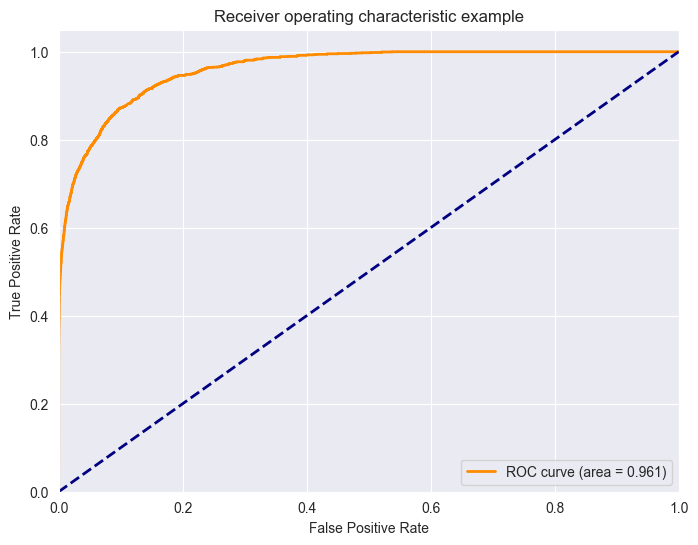

In [12]:
lr_diabetes_result = train_evaluate_lr(X_train_rus_dia, X_test_scaled_diabetes, y_train_rus_dia, y_test_diabetes, model_name='Diabetes Dataset Logistic Regression')
rf_diabetes_result = train_evaluate_rf(X_train_rus_dia, X_test_scaled_diabetes, y_train_rus_dia, y_test_diabetes, model_name='Diabetes Dataset Random Forest')
svm_diabetes_result = train_evaluate_svm(X_train_rus_dia, X_test_scaled_diabetes, y_train_rus_dia, y_test_diabetes, model_name='Diabetes Dataset SVM')